In [30]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc,roc_curve,roc_auc_score
from sklearn import preprocessing

from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data preparation

## Load the model we use in the project

In [3]:
model = keras.models.load_model('model.h5')

## Define the path of our dataset

In [4]:
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));
        
base_dir = 'kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'

os.listdir(base_dir)

kaggle/input\challenges-in-representation-learning-facial-expression-recognition-challenge\example_submission.csv
kaggle/input\challenges-in-representation-learning-facial-expression-recognition-challenge\fer2013.tar.gz
kaggle/input\challenges-in-representation-learning-facial-expression-recognition-challenge\icml_face_data.csv
kaggle/input\challenges-in-representation-learning-facial-expression-recognition-challenge\test.csv
kaggle/input\challenges-in-representation-learning-facial-expression-recognition-challenge\train.csv


['example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv']

## Read the entire dataset

In [7]:
df = pd.read_csv(base_dir+'icml_face_data.csv')
df.columns = ['emotion', 'Usage', 'pixels']

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

## Prepare data for training, testing and validating

In [16]:
train_data = df[df['Usage']=='Training']
train_data.drop(columns='Usage', inplace=True)

In [10]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [17]:
X_train, y_train = prepare_data(train_data)

In [18]:
test_data = df[df['Usage']!='Training']
test_data.drop(columns='Usage', inplace=True)

#prepare data
X_test, y_test = prepare_data(test_data)

In [21]:
#train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  shuffle=True, 
                                                  stratify=y_train,
                                                  test_size=0.2, 
                                                  random_state=121)

In [24]:
#encode train labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train)

#ecode test labels
y_test = le.transform(y_test)
y_test = keras.utils.to_categorical(y_test)

#ecode val labels
y_val = le.transform(y_val)
y_val = keras.utils.to_categorical(y_val)

In [25]:
#make prediction
y_test = np.argmax(y_test, axis=1)
yhat_test = np.argmax(model.predict(X_test), axis=1)

# Grad-CAM

In [26]:
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

## Show some examples using Grad-CAM

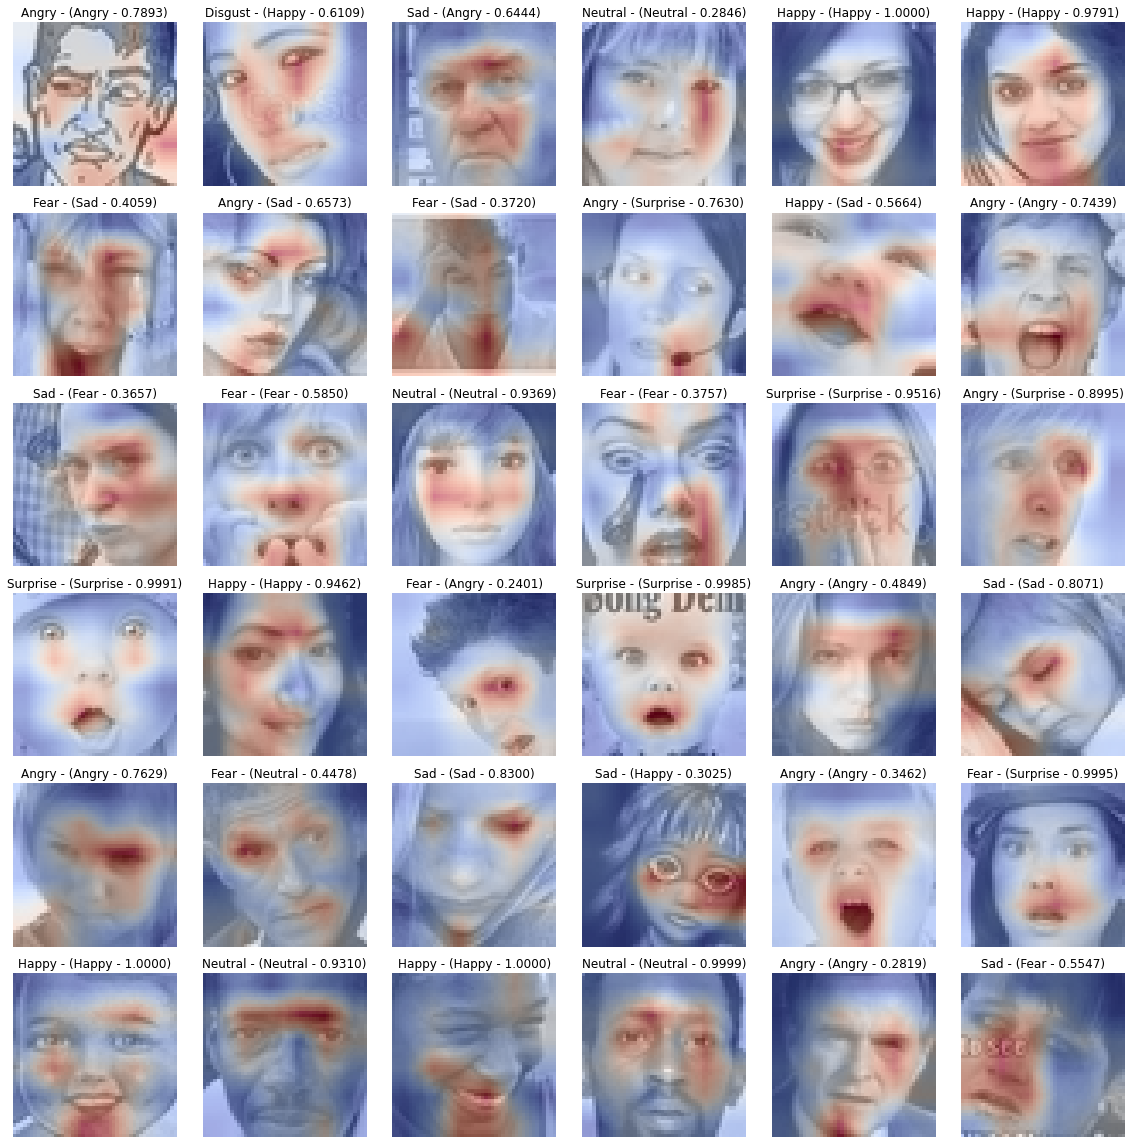

In [31]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1, 48, 48, 1))

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Show probability distribution 

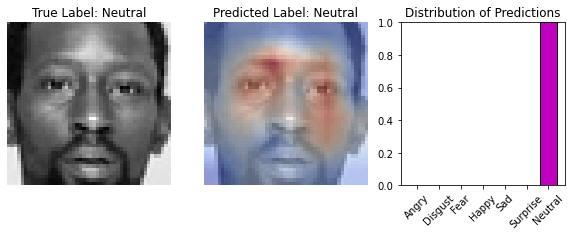

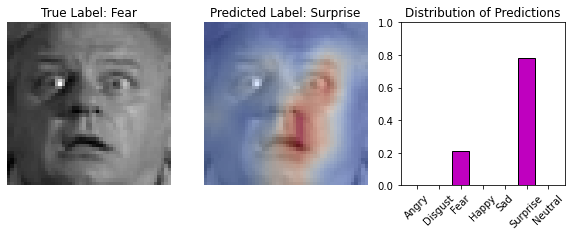

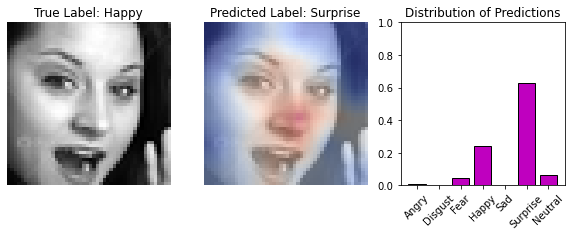

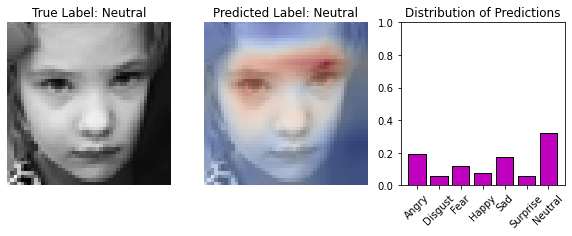

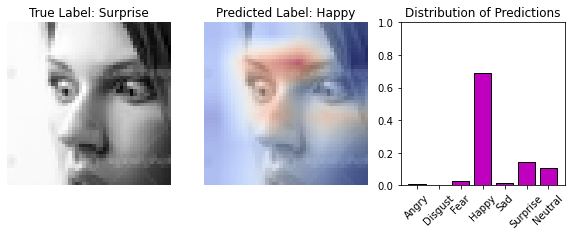

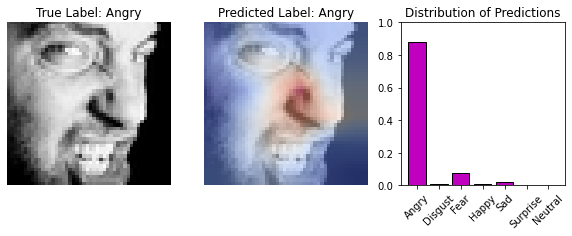

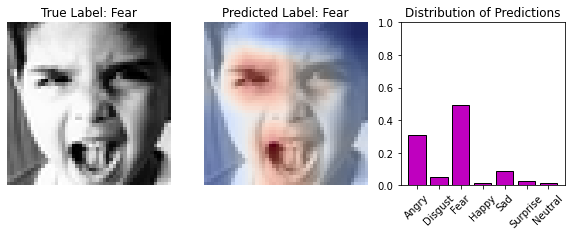

In [32]:
test_prob = model.predict(X_test)
test_pred = np.argmax(test_prob, axis=1)

sel_imgs = [33, 1000, 88, 777, 108, 111, 7000]

for n in sel_imgs:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='m', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

## Correct predictions

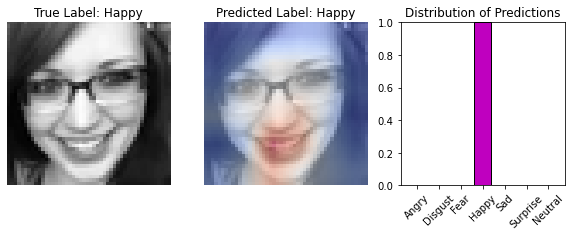

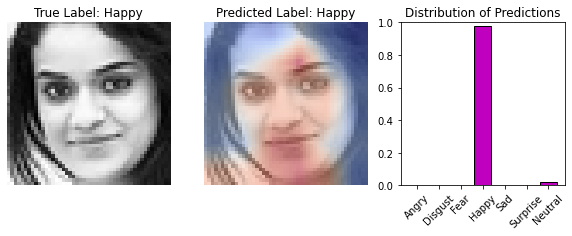

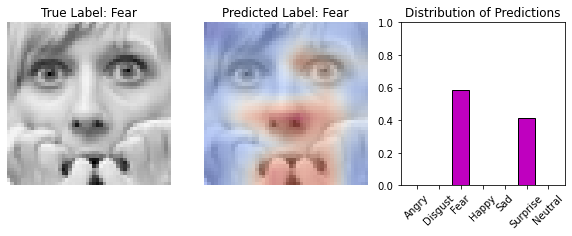

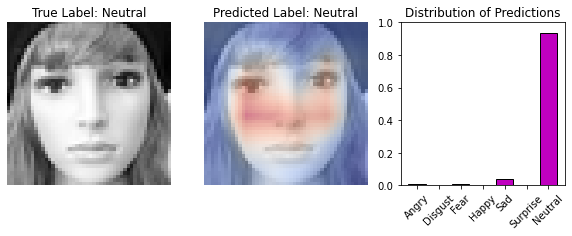

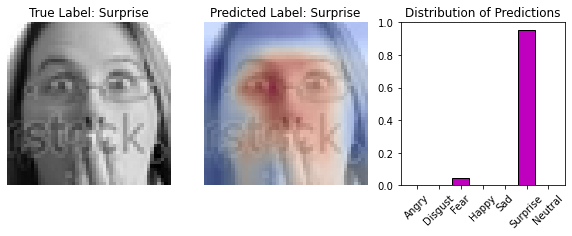

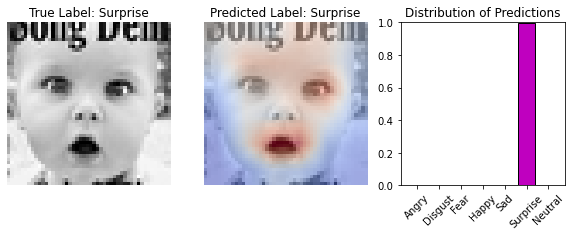

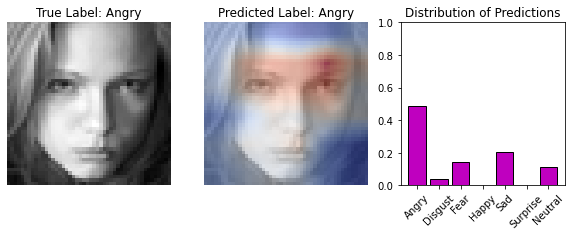

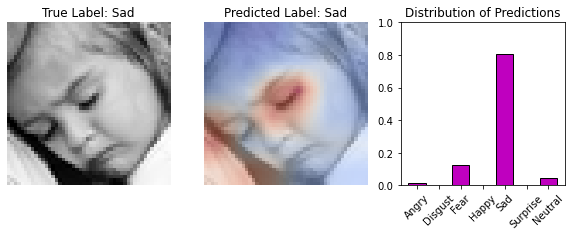

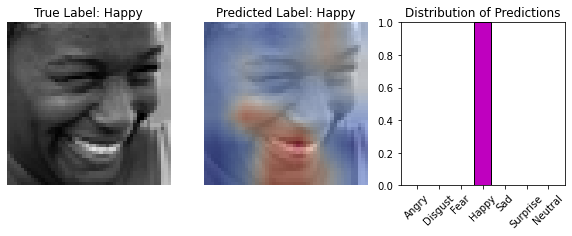

In [58]:
idx = [4,5,13,14,16,21,22,23,32]

for n in idx:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='m', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

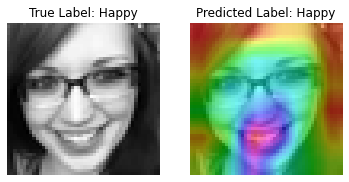

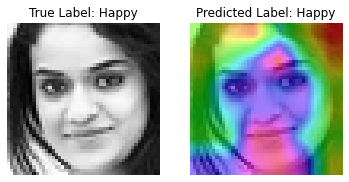

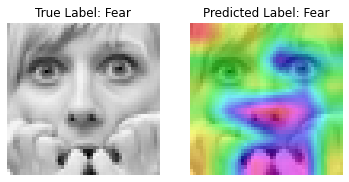

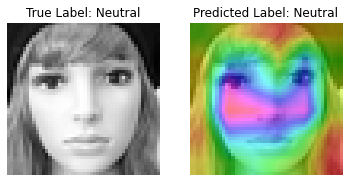

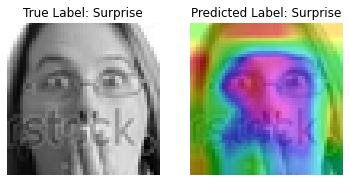

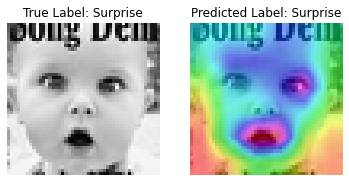

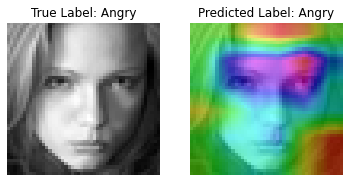

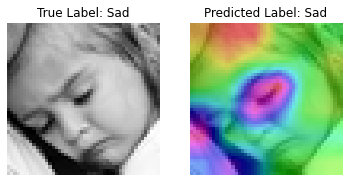

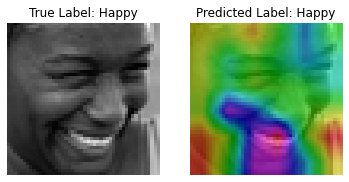

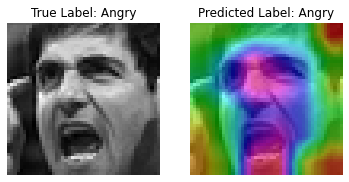

In [42]:
idx = [4,5,13,14,16,21,22,23,32,151]

for n in idx:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[6,3])
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')

## Wrong predictions

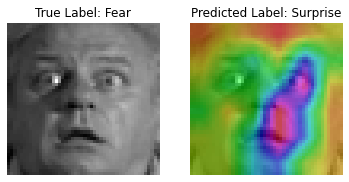

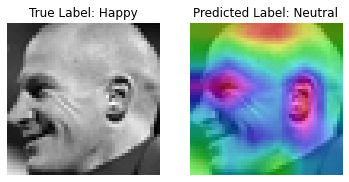

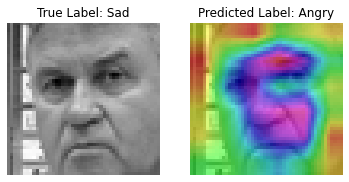

In [63]:
idx = [1000,45,2]

for n in idx:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[6,3])
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')